In [1]:
import os
from pathlib import Path
from functools import reduce

import pandas as pd
import numpy as np

from dokdonia import differentialexpression as DE
from dokdonia.pathway import KEGGPathwayParser, GenomeGBK, add_pathways_to_deseq_df
from dokdonia.utils import save_to_pickle_file

%matplotlib inline


root_dir = Path(os.getcwd()).parent
results_dir = root_dir / "results"
data_dir = root_dir / "data"

## Load counts

In [2]:
min_count = 10

counts = pd.read_csv(data_dir / 'counts' / 'DokdoniaCounts.csv', index_col=0)
counts = counts[counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)

## Load KEGG pathways and genome annotations

In [3]:
gbk = GenomeGBK(data_dir / 'genome' / 'DokdoniaMED134.gbk')

KEGGparser = KEGGPathwayParser.fromKEGGidentifier('dok', only_curated_pathways=True)
gene_pathways, gene_systems = KEGGparser.getGenePathways()
system_pathways = KEGGparser.getSystemPathways()
# gene_info = KEGGparser.getGeneInfoFromKEGGorthology()
gene_list = list(gene_pathways.keys())
print(f'There are a total of {len(gene_list)} genes')

There are a total of 782 genes


# Find DE genes

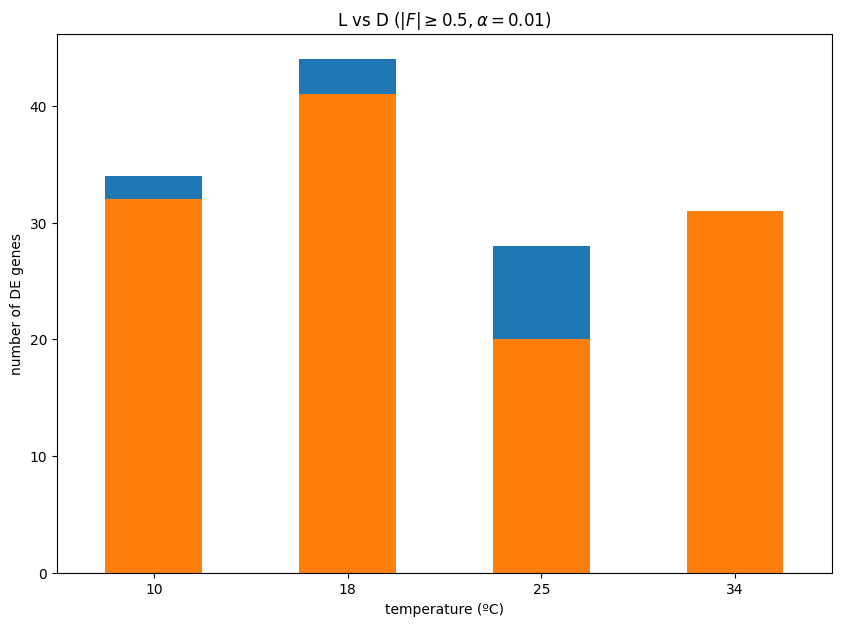

In [4]:
p_value_cutoff = 1e-2
fold_cutoff = k = 0.5

# DE light vs dark across temperatures
L_D_res, L_D_stats = {}, {}
L_D_res['all'], L_D_stats['all'] = DE.runDEtest(counts, test='Wald', alpha=p_value_cutoff,
                                                formula='~ lighting', log2fold_cutoff=k)
# L vs D for each temperature
for T in ['10', '18', '25', '34']:
    counts_T = counts[counts.filter(regex=f'{T}|index').columns]    
    L_D_res[T], L_D_stats[T] = DE.runDEtest(counts_T, test='Wald', alpha=p_value_cutoff,
                                            formula='~ lighting', log2fold_cutoff=k)
# Plot stats
ax = pd.DataFrame(L_D_stats).drop("all", axis=1).transpose().plot.bar(
    stacked=True, title=f'L vs D ($|F|\\geq 0.5,\\alpha={p_value_cutoff}$)',
    figsize=(10, 7), ylabel='number of DE genes', xlabel='temperature (ºC)',
    rot=0, color=['C1', 'C0'], legend=False)

In [5]:
DELD = {}
for T, res in L_D_res.items():
    DELD[T] = {
        'L>D': add_pathways_to_deseq_df(
            res.loc[res.log2FoldChange >= k].sort_values(by="log2FoldChange", ascending=False),
            gbk,
            gene_pathways,
            gene_systems
        ),
        'D>L': add_pathways_to_deseq_df(
            res.loc[res.log2FoldChange <= -k].sort_values(by="log2FoldChange", ascending=False),
            gbk,
            gene_pathways,
            gene_systems
        ),
    }

# Save to pickle
save_to_pickle_file(DELD, results_dir / "deseq_results" / "DELD.pkl")

# Find intersections
data_L_D = [DELD[T]["L>D"][["product", "subsystem", "system"]] for T in ['10', '18', '25', '34']]
df_merged_L_D = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True), data_L_D)
# Remove duplicated cols
df_merged_L_D = df_merged_L_D[["product_x", "subsystem_x", "system_x"]]
df_merged_L_D = df_merged_L_D.loc[:, ~df_merged_L_D.columns.duplicated()]
# D - L
data_D_L = [DELD[T]["D>L"][["product", "subsystem", "system"]] for T in ['10', '18', '25', '34']]
df_merged_D_L = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True), data_D_L)
# Remove duplicated cols
df_merged_D_L = df_merged_D_L[["product_x", "subsystem_x", "system_x"]]
df_merged_D_L = df_merged_D_L.loc[:, ~df_merged_D_L.columns.duplicated()]

# Write to Excel
excel_out = results_dir / "deseq_results" / "light_dark_deseq2.xlsx"
with pd.ExcelWriter(excel_out) as writer:  
    for temp, cond_res in DELD.items():
        for cond, df in cond_res.items():
            if "value" in df.columns:
                df = df.rename({"value": "log2FoldChange"}, axis=1)
            df.to_excel(writer, sheet_name=f"{temp}_{cond}")


    df_merged_L_D.to_excel(writer, sheet_name="common_genes_L>D")
    df_merged_D_L.to_excel(writer, sheet_name="common_genes_D>L")

/tmp/ipykernel_34798/2723736133.py:23: FutureWarning: Passing 'suffixes' which cause duplicate columns {'system_x', 'product_x', 'subsystem_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_merged_L_D = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True), data_L_D)
/tmp/ipykernel_34798/2723736133.py:29: FutureWarning: Passing 'suffixes' which cause duplicate columns {'system_x', 'product_x', 'subsystem_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_merged_D_L = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True), data_D_L)


# Effect of temperature on L-D DE genes
How do DE genes across light and dark behave across temperatures?

In [6]:
# Get light-dark DE genes at any temperature
k = 0.5
DE_all_T  = np.unique([g for g in L_D_res['all'][abs(L_D_res['all'].log2FoldChange) >= k].index]).tolist()
DE_plus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange >= k].index]).tolist()
DE_minus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange <= -k].index]).tolist()
DE_total = DE_plus + DE_minus

# Save to pickle file
save_to_pickle_file(DE_all_T, results_dir / "deseq_results" / "DE_all_T.pkl")
save_to_pickle_file(DE_plus, results_dir / "deseq_results" / "DE_plus.pkl")
save_to_pickle_file(DE_minus, results_dir / "deseq_results" / "DE_minus.pkl")
save_to_pickle_file(DE_total, results_dir / "deseq_results" / "DE_total.pkl")

print(f'There are a total of {len(DE_total)} DE genes between Light and Dark')
print(f'There a total of {len(DE_all_T)} Light/Dark DE genes across the entire T range')

There are a total of 74 DE genes between Light and Dark
There a total of 14 Light/Dark DE genes across the entire T range


## DE on multiple comparisons across temperatures
See https://hbctraining.github.io/DGE_workshop/lessons/08_DGE_LRT.html
Fold changes here aren't meaningful.

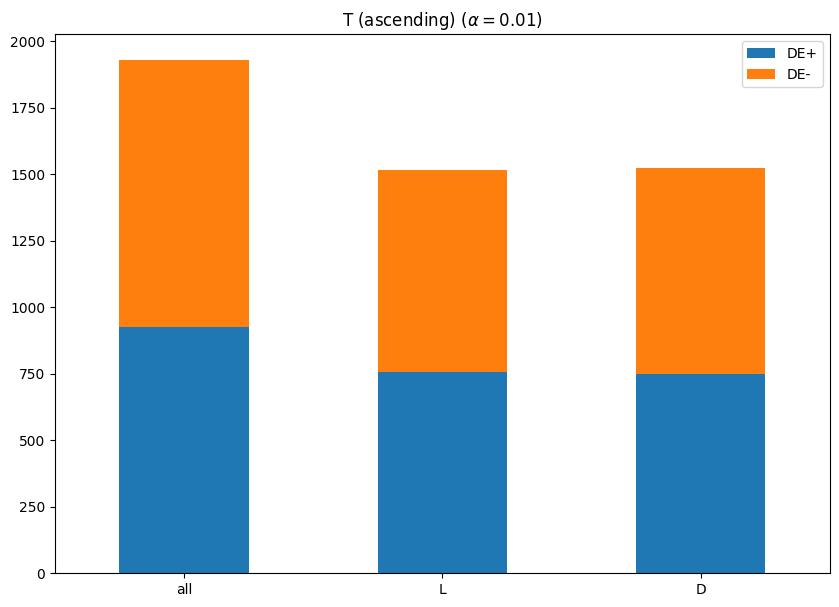

In [7]:
# Do not discriminate between Light and Dark conditions
T_res, T_stats = {}, {}
T_res['all'], T_stats['all'] = DE.runDEtest(counts, test='LRT', alpha=p_value_cutoff,
                                            formula='~ temperature', reduced_formula='~ 1')

# Discriminate between Light and Dark conditions
for L in ['L', 'D']:
    counts_L = counts[counts.filter(regex=f'{L}|index').columns]    
    T_res[L], T_stats[L] = DE.runDEtest(counts_L, test='LRT', alpha=p_value_cutoff,
                                        formula='~ temperature', reduced_formula='~ 1')

save_to_pickle_file(T_res, results_dir / "deseq_results" / "DE_result.pkl")

# Plot stats
ax = pd.DataFrame(T_stats).transpose().plot.bar(
    stacked=True, title=f'T (ascending) ($\\alpha={p_value_cutoff}$)', figsize=(10, 7), rot=0)

In [8]:
# Write to excel, add pathways
excel_out = results_dir /"deseq_results" / "across_temperature_deseq2.xlsx"
with pd.ExcelWriter(excel_out) as writer:

    for cond, res in T_res.items():
        res = add_pathways_to_deseq_df(
            res,
            gbk,
            gene_pathways,
            gene_systems
            ).drop("log2FoldChange", axis=1)
        res.to_excel(writer, sheet_name=f"{cond}")

In [9]:
# Find genes which are DE across the temperature range
DE_genes_across_T = list(T_res["all"].index)
save_to_pickle_file(DE_genes_across_T, results_dir / "deseq_results" / "DE_genes_across_T.pkl")
print(f"There are {len(DE_genes_across_T)} out of {counts.shape[0]} genes which are DE across all temperature values")

There are 1930 out of 2877 genes which are DE across all temperature values
